In [1]:
# import packages
from datetime import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# For reading files and directories
import os

# Reading images into numpy arrays
from PIL import Image

# splitting, training, and testing
import sklearn.model_selection as ms

# Visualization
import sklearn.metrics as skm

# Eigenfaces and SVM
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

# edge detection
from skimage import feature

# histogram of oriented gradients
from skimage.feature import hog


%matplotlib inline

In [2]:
def plot_gallery(images, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

In [3]:
def plot_singleFace(image,h,w):
    """Helper function to plot a single image"""
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

Import all images and convert to 3D numpy arrays. Then parse information for each image into dicts.

In [4]:
# create list to hold numpy arrays for each image
images = []
dirname = "./colorferet/front_smaller/"
for filename in sorted(os.listdir(dirname)):
    #print(filename)
    im = Image.open(os.path.join(dirname, filename)).convert("L") # "L" means b/w. comment out for color
    images.append(np.asarray(im, dtype=np.uint8))

X = np.array(images)
n_samples, height, width = X.shape
X = X.reshape([1364,-1])

print("Image size: \t\t[",width,",",height,"]")
print("Original image size:\t[ 512 , 768 ]")
print("Dimensions of X: \t[",X.shape[0],",",X.shape[1],"]")

Image size: 		[ 256 , 384 ]
Original image size:	[ 512 , 768 ]
Dimensions of X: 	[ 1364 , 98304 ]


In [5]:
# create list of dictionaries for each image's attributes
imData = [{} for _ in range(n_samples)]

dirname = "./colorferet/truths/"
filenames = sorted(os.listdir(dirname))
for i in range(n_samples):
    filename = filenames[i]
    textfile = open(os.path.join(dirname, filename))
    for str in textfile.read().split('\n'):
        if len(str) > 0:
            key, value = str.split('=')
        imData[i][key] = value
    textfile.close()

#imData[0]

In [6]:
# Create an index which gives all individuals with coordinate information
key = "nose_coordinates"
coord_idx = []
for i in range(n_samples):
    if key in imData[i]:
        coord_idx.append(i)
        imData[i]["x_nose"] = round(int(imData[i]["nose_coordinates"].rsplit(' ',1)[0])/2)
        imData[i]["y_nose"] = round(int(imData[i]["nose_coordinates"].rsplit(' ',1)[1])/2)
        imData[i]["x_leye"] = round(int(imData[i]["left_eye_coordinates"].rsplit(' ',1)[0])/2)
        imData[i]["x_reye"] = round(int(imData[i]["right_eye_coordinates"].rsplit(' ',1)[0])/2)
        imData[i]["y_leye"] = round(int(imData[i]["left_eye_coordinates"].rsplit(' ',1)[1])/2)
        imData[i]["y_reye"] = round(int(imData[i]["right_eye_coordinates"].rsplit(' ',1)[1])/2)
        imData[i]["x_mout"] = round(int(imData[i]["mouth_coordinates"].rsplit(' ',1)[0])/2)        
        imData[i]["y_mout"] = round(int(imData[i]["mouth_coordinates"].rsplit(' ',1)[1])/2)
                
        imData[i]["xdiff_eye"] = imData[i]["x_leye"] - imData[i]["x_reye"]
        imData[i]["ydiff_e2m"] = imData[i]["y_mout"] - np.mean((imData[i]["y_reye"],imData[i]["y_leye"]))
        
# removes irrelevant X & imData indices
imData = [imData[i] for i in coord_idx]
X = X[coord_idx]
n_samples = X.shape[0]

print("Dimensions of X: \t[",X.shape[0],",",X.shape[1],"]")

print("Samples with coordinate information: {:3.1f}%".format(100*len(coord_idx)/n_samples))

Dimensions of X: 	[ 1207 , 98304 ]
Samples with coordinate information: 100.0%


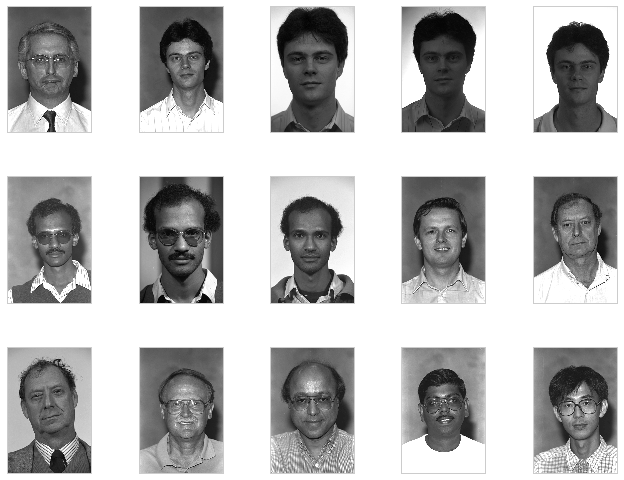

In [7]:
# Plot of first 15 images
plot_gallery(X[0:15], height, width)

Let's train a classifier to look for a mustache, glasses, or beard

In [8]:
# First let us crop each image so that it only shows the region near where the feature might be
# Original image size is four times larger than thumbnail so coordinates are scaled by 1/4

y = []
x_nose    = np.ndarray([0])
x_leye    = np.ndarray([0])
y_leye    = np.ndarray([0])
x_reye    = np.ndarray([0])
y_reye    = np.ndarray([0])
y_nose    = np.ndarray([0])
x_mout    = np.ndarray([0])
y_mout    = np.ndarray([0])
xdiff_eye = np.ndarray([0])
ydiff_e2m = np.ndarray([0])
for i in range(n_samples):
#    y.append(imData[i]['mustache'])
    y.append(imData[i]['glasses'])
#    y.append(imData[i]['beard'])

    x_leye = np.append(x_leye,int(imData[i]['x_leye']))
    y_leye = np.append(y_leye,int(imData[i]['y_leye']))
    x_reye = np.append(x_reye,int(imData[i]['x_reye']))
    y_reye = np.append(y_reye,int(imData[i]['y_reye']))
    x_nose = np.append(x_nose,int(imData[i]['x_nose']))
    y_nose = np.append(y_nose,int(imData[i]['y_nose']))
    x_mout = np.append(x_mout,int(imData[i]['x_mout']))
    y_mout = np.append(y_mout,int(imData[i]['y_mout']))
    xdiff_eye = np.append(xdiff_eye,int(imData[i]['xdiff_eye']))
    ydiff_e2m = np.append(ydiff_e2m,int(imData[i]['ydiff_e2m']))
    
y = pd.Series(y).replace(['No','Yes'],[0,1]).as_matrix()

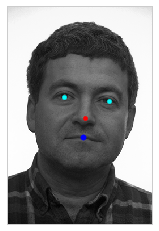

In [9]:
idx = 25
Ximg = X[idx].reshape((height,width))
plot_singleFace(Ximg,height,width)
plt.scatter(x_nose[idx],y_nose[idx],color='red',s=20)
plt.scatter(x_leye[idx],y_leye[idx],color='cyan',s=20)
plt.scatter(x_reye[idx],y_reye[idx],color='cyan',s=20)
plt.scatter(x_mout[idx],y_mout[idx],color='blue',s=30)

In [10]:
# crop for glasses
height_new = 80
width_new  = 120
Xcrop = np.zeros((n_samples,height_new*width_new))
for i in range(n_samples):
    Ximg = X[i,:].reshape((height,width))
    Xtop = int((y_reye[i]+y_leye[i])/2 + height_new/2)
    Xbot = int((y_reye[i]+y_leye[i])/2 - height_new/2)
    Xl   = int((x_reye[i]+x_leye[i])/2 - width_new/2)
    Xr   = int((x_reye[i]+x_leye[i])/2 + width_new/2)
    Xcrop[i,:] = Ximg[ Xbot : Xtop , Xl : Xr].flatten()
     
Xcrop.shape

(1207, 9600)

In [11]:
# split into training and testing sets
indices = np.arange(X.shape[0])
trainSize = 0.8
X_train, X_test, y_train, y_test, idx_train, idx_test = ms.train_test_split(Xcrop,y,indices, train_size=trainSize)

Extracting the top 120 eigenfaces from 965 faces


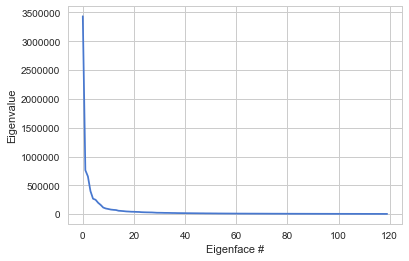

In [12]:
nPCA = 120

print("Extracting the top %d eigenfaces from %d faces"
      % (nPCA, X_train.shape[0]))
pca = PCA(n_components=nPCA, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenvalues = pca.explained_variance_
plt.figure(figsize=(6,4))
plt.plot(eigenvalues)
plt.xlabel("Eigenface #")
plt.ylabel("Eigenvalue")

Projecting the input data on the eigenfaces orthonormal basis


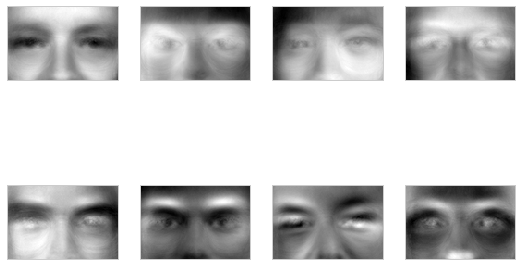

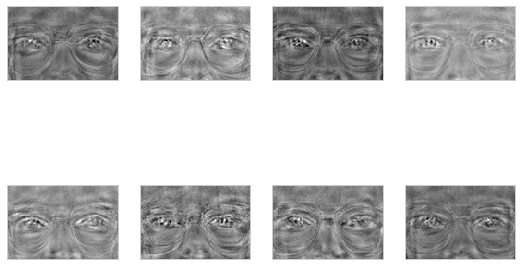

In [13]:
print("Projecting the input data on the eigenfaces orthonormal basis")

eigenfaces = pca.components_.reshape([nPCA, height_new, width_new])
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot them creepy pictures
plot_gallery(eigenfaces[:8], height_new, width_new, 2, 4)
plot_gallery(eigenfaces[-8:], height_new, width_new, 2, 4)

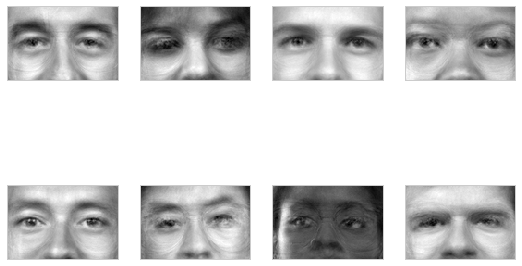

In [14]:
ImBack = pca.inverse_transform(X_train_pca)
plot_gallery(ImBack[:8], height_new, width_new, 2, 4)

In [15]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1e1, 1e2, 1e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

trainWeights = np.ones(len(y_train))
trainWeights[np.where(y_train==1)] = (len(y_train) - np.sum(y_train))/np.sum(y_train) 

clf = GaussianNB()
clf.fit(X_train_pca, y_train, sample_weight = trainWeights)


Fitting the classifier to the training set


GaussianNB(priors=None)

In [16]:
y_pred = clf.predict(X_test_pca)
print("Results (train size = ",trainSize*100,"%)")
print(skm.classification_report(y_test, y_pred, target_names=['No Glasses', 'Glasses']))

Results (train size =  80.0 %)
             precision    recall  f1-score   support

 No Glasses       0.94      0.94      0.94       218
    Glasses       0.45      0.42      0.43        24

avg / total       0.89      0.89      0.89       242



Glasses? (Actual) : [0 0 1 0 0 0 0 0 0 0]
Glasses? (Predic) : [0 0 1 0 0 0 0 0 0 0]


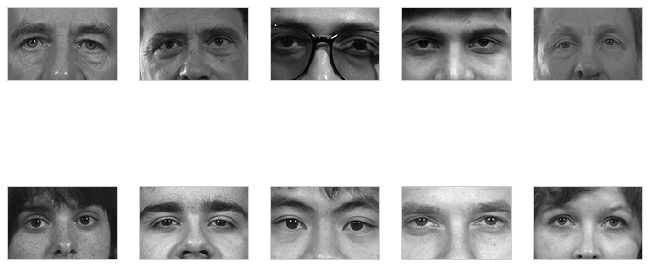

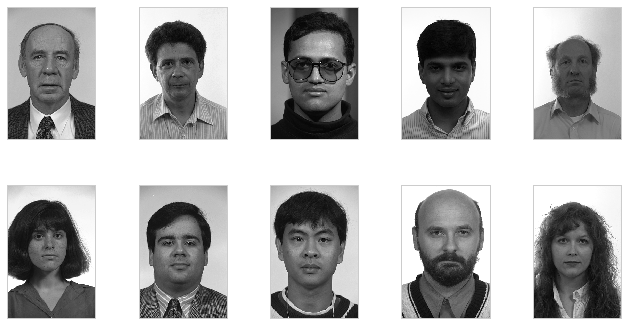

In [17]:
idx = range(100,110)
plot_gallery(X_test[idx],height_new,width_new,int(len(idx)/5), 5)
print("Glasses? (Actual) :",y_test[idx])
print("Glasses? (Predic) :",y_pred[idx])
plot_gallery(X[idx_test[idx]],height,width,int(len(idx)/5), 5)

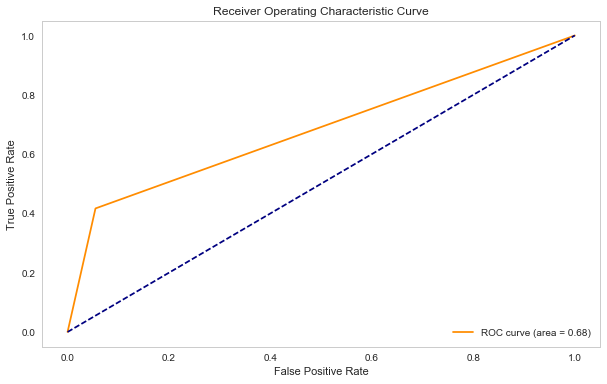

In [18]:
# predicted values
Yscore = clf.predict(X_test_pca)

# false and true positive rates
fpr, tpr, thr = skm.roc_curve(np.array(y_test), Yscore)

# area under ROC curve
roc_auc = skm.auc(fpr, tpr)

plt.figure(figsize=[10,6])
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")